In [2]:
import os
import sys
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
# from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [5]:
from src.preprocessing.preprocessing  import data_wrangling, llenar_val_vacios_str,llenar_val_vacios_ciclo,TsfelVars, ExtraVars,ToDummy, TeEncoder, CardinalityReducer
from src.modeling.feature_selection import feature_selection_by_constant, feature_selection_by_boruta, feature_selection_by_correlation
from src.modeling.supervided_models import LGBMModel, NNModel, LSTMNNModel
from src.helper.helper_functions import plot_roc

In [6]:
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.2f}'.format #evita que muestre notacion cientifica
pd.set_option('display.max_columns', None)
np.set_printoptions(suppress=True) #evita mostrar notacion cientifica

In [7]:
# colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# mpl.rcParams['figure.figsize'] = (12, 10)

In [8]:
seed = 2021
np.random.seed(seed)

## Paso 1 - Leer datos

In [9]:
df = pd.read_parquet('../datos/df_anonimizado_02-2023.parquet')

In [10]:
df.head()

,index,12_anterior,11_anterior,10_anterior,9_anterior,8_anterior,7_anterior,6_anterior,5_anterior,4_anterior,3_anterior,2_anterior,1_anterior,zona,actividad,tipo_tarifa,nivel_tension,material_instalacion,fecha_inspeccion,target
50345,50345,nan,nan,nan,nan,nan,62.00,58.00,57.00,69.00,95.00,108.00,106.00,zona_660487,actividad_523376,tipo_tarifa_149261,nivel_tension_197436,material_instalacion_143521,2016-05-01,1
191551,191551,92.00,87.00,82.00,74.00,82.00,85.00,86.00,96.00,126.00,104.00,119.00,132.00,zona_647593,actividad_523376,tipo_tarifa_149261,nivel_tension_197436,material_instalacion_143521,2017-05-01,1
8259,8259,20.00,19.00,27.00,33.00,21.00,21.00,21.00,23.00,18.00,15.00,10.00,14.00,zona_660487,actividad_523376,tipo_tarifa_149261,nivel_tension_685394,material_instalacion_250300,2016-01-01,1
287671,287671,51.00,70.00,135.00,89.00,112.00,106.00,106.00,52.00,31.00,0.00,0.00,0.00,zona_824219,actividad_523376,tipo_tarifa_149261,nivel_tension_197436,material_instalacion_143521,2018-01-01,1
306877,306877,0.00,27.00,46.00,43.00,39.00,40.00,37.00,39.00,36.00,34.00,35.00,32.00,None,None,None,None,material_instalacion_143521,2018-03-01,1


In [11]:
df.shape

(42500, 20)

In [12]:
df.dtypes

index                            int64
12_anterior                    float64
11_anterior                    float64
10_anterior                    float64
9_anterior                     float64
8_anterior                     float64
7_anterior                     float64
6_anterior                     float64
5_anterior                     float64
4_anterior                     float64
3_anterior                     float64
2_anterior                     float64
1_anterior                     float64
zona                            object
actividad                       object
tipo_tarifa                     object
nivel_tension                   object
material_instalacion            object
fecha_inspeccion        datetime64[ns]
target                           int64
dtype: object

In [13]:
df.target.mean()

0.058823529411764705

## Paso 2 - Particionar datos

In [14]:
#Particionar por fecha
df_train = df[df.fecha_inspeccion<'2017-08-01'].copy()
df_val = df[(df.fecha_inspeccion>='2017-09-01')&(df.fecha_inspeccion<'2018-01-01')].copy()
df_test = df[df.fecha_inspeccion>='2018-01-01'].copy()

In [15]:
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(26533, 20)
(4323, 20)
(9995, 20)


## Paso 3 - Procesamiento de datos

In [16]:
df_train.isnull().sum()

index                      0
12_anterior               33
11_anterior               31
10_anterior               22
9_anterior                20
8_anterior                18
7_anterior                11
6_anterior                22
5_anterior                36
4_anterior                51
3_anterior                62
2_anterior                81
1_anterior                89
zona                    2882
actividad               2882
tipo_tarifa             2882
nivel_tension           2894
material_instalacion       0
fecha_inspeccion           0
target                     0
dtype: int64

In [17]:
df_train = llenar_val_vacios_ciclo(df_train, 12)
cols_fillna_sindatos = ['zona','actividad','tipo_tarifa','nivel_tension']
df_train = llenar_val_vacios_str(df_train,cols_fillna_sindatos,'sin_dato')

### Tratamiento de las variables de consumo

In [18]:
variables_consumo = [x for x in df.columns if '_anterior' in x]
df_consumos = df_train[['index']+variables_consumo].head(12000)

In [19]:
pipe_feature_engeniering_consumo = Pipeline(
    [
        ("tsfel vars", TsfelVars(features_names_path=None,num_periodos= 12)),
        ("add vars3",  ExtraVars(num_periodos=3)),
        ("add vars6",  ExtraVars( num_periodos=6)),
        ("add vars12", ExtraVars(num_periodos=12)),

    ]
        )

In [20]:
df_features = pipe_feature_engeniering_consumo.fit_transform(df_consumos)

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***


### Feature selection

In [21]:
cols_for_feature_sel = [x for x in df_features.columns if x not in ['index'] + variables_consumo]
y_train = df_train.loc[df_features['index']].target

In [22]:
%%time
select_by_constant = feature_selection_by_constant(df_features, y_train, cols_for_feature_sel, th=0.99)
# pd.Series(sorted(select_by_constant)).to_csv('tmp/features_by_constante_12.csv', index=False)
print(f" # variables No constantes {len(select_by_constant)}")

 # variables No constantes 64
CPU times: user 107 ms, sys: 0 ns, total: 107 ms
Wall time: 106 ms


In [23]:
%%time
select_by_corr = feature_selection_by_correlation(df_features, y_train, select_by_constant,method='pearson', th=0.95)
# pd.Series(sorted(select_by_corr)).to_csv('tmp/features_by_corr_12.csv', index=False)
print(f" # variables No correlacionadas {len(select_by_corr)}")

Calculando Correlación Entre Variables
Eliminando Variables Altamente Correlacionadas
 # variables No correlacionadas 34
CPU times: user 180 ms, sys: 7.66 ms, total: 188 ms
Wall time: 186 ms


In [24]:
%%time
select_by_boruta = feature_selection_by_boruta(df_features[select_by_constant], y_train, N=5)
# pd.Series(sorted(select_by_boruta)).to_csv('tmp/features_by_const_boruta_12.csv', index=False)
print(f" # variables seleccionadas por Boruta : {len(select_by_boruta)}")

100%|██████████| 5/5 [05:27<00:00, 65.50s/it]

 # variables seleccionadas por Boruta : 47
CPU times: user 44min 2s, sys: 24 s, total: 44min 26s
Wall time: 5min 27s


In [25]:
select_by_boruta

['0_Centroid',
 'max_cons3',
 'min_cons3',
 'mean_6',
 'mean_3',
 'min_cons6',
 'std_cons6',
 'var_cons6',
 'std_cons3',
 '0_Area under the curve',
 '0_Standard deviation',
 'mean_12',
 '0_Root mean square',
 'var_cons3',
 '0_ECDF Percentile_0',
 '0_Median',
 '0_ECDF Percentile_1',
 '0_Mean',
 'std_cons12',
 '0_Min',
 'min_cons12',
 'var_cons12',
 '0_Variance',
 'slope_6',
 '0_Total energy',
 '0_Peak to peak distance',
 '0_Absolute energy',
 'max_cons12',
 '0_Autocorrelation',
 '0_Max',
 '0_Interquartile range',
 '0_Signal distance',
 '0_Mean absolute deviation',
 '0_Mean diff',
 '0_Mean absolute diff',
 '0_Median absolute diff',
 'max_cons6',
 'kurt_cons6',
 '0_Entropy',
 '0_Slope',
 'slope_12',
 'skew_cons3',
 '0_Sum absolute diff',
 '0_Median absolute deviation',
 'kurt_cons12',
 '0_Skewness',
 'max_cant_ceros_seg_3']

In [26]:
print('Feature Selection : Fin')

Feature Selection : Fin


### Tratamiento de las variables categoricas

In [27]:
variables_categoricas = ['zona','actividad','material_instalacion','tipo_tarifa','nivel_tension']

In [28]:
df_train[variables_categoricas].head()

,zona,actividad,material_instalacion,tipo_tarifa,nivel_tension
50345,zona_660487,actividad_523376,material_instalacion_143521,tipo_tarifa_149261,nivel_tension_197436
191551,zona_647593,actividad_523376,material_instalacion_143521,tipo_tarifa_149261,nivel_tension_197436
8259,zona_660487,actividad_523376,material_instalacion_250300,tipo_tarifa_149261,nivel_tension_685394
9332,zona_489241,actividad_523376,material_instalacion_143521,tipo_tarifa_149261,nivel_tension_197436
157486,zona_647593,actividad_960696,material_instalacion_250300,tipo_tarifa_149261,nivel_tension_197436


## Paso 4 - Entrenamiento de Modelos

In [29]:
y_train = df_train.target.copy()
df_train = df_train.drop(columns=['target'])

y_val = df_val.target.copy()
df_val = df_val.drop(columns=['target'])

y_test = df_test.target.copy()
df_test = df_test.drop(columns=['target'])

In [30]:
df_val = llenar_val_vacios_ciclo(df_val, 12)

df_val = llenar_val_vacios_str(df_val,cols_fillna_sindatos,'sin_dato')

df_test = llenar_val_vacios_ciclo(df_test, 12)
df_test = llenar_val_vacios_str(df_test,cols_fillna_sindatos,'sin_dato')

In [31]:
df_train = pipe_feature_engeniering_consumo.fit_transform(df_train)
df_val = pipe_feature_engeniering_consumo.transform(df_val)
df_test = pipe_feature_engeniering_consumo.transform(df_test)

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***


In [32]:
feauture_selected = select_by_boruta
cols_for_model = variables_categoricas+variables_consumo+feauture_selected

In [33]:
param_imb_method = 'under'
periodo = 12
preprocesor = 4
sam_th = 0.2

In [34]:
resulado_final = {}

## LGBM

In [35]:
%%time
train_lgbm_model = LGBMModel(cols_for_model,
                             hyperparams=None,
                             search_hip=True,
                             sampling_th = sam_th,
                             preprocesor_num = preprocesor,
                             sampling_method=param_imb_method)
lgbm_model = train_lgbm_model.train(df_train,y_train,df_val, y_val)


Best score reached: 0.7184494499908558 with params: {'lgbmclassifier__colsample_bytree': 0.5724726792874275, 'lgbmclassifier__learning_rate': 0.09042371348412374, 'lgbmclassifier__max_bin': 128, 'lgbmclassifier__max_depth': 5, 'lgbmclassifier__min_child_samples': 240, 'lgbmclassifier__min_child_weight': 0.001, 'lgbmclassifier__num_leaves': 40, 'lgbmclassifier__reg_alpha': 5, 'lgbmclassifier__reg_lambda': 0.001, 'lgbmclassifier__scale_pos_weight': 5, 'lgbmclassifier__subsample': 0.8087445946527063, 'lgbmclassifier__subsample_freq': 11} 
CPU times: user 7.73 s, sys: 596 ms, total: 8.33 s
Wall time: 13.5 s


In [36]:
y_pred_test_lgbm = lgbm_model.predict_proba(df_test[cols_for_model])[:,1]
resulado_final[f'{param_imb_method}-lgbm'] = y_pred_test_lgbm

In [37]:
print("AUC Test:  %.3f" %  roc_auc_score(y_test,y_pred_test_lgbm))

AUC Test:  0.776


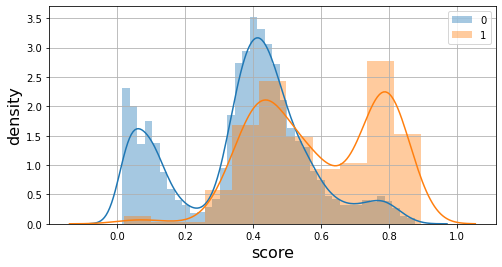

In [38]:
plt.figure(figsize=(8,4))
sns.distplot(y_pred_test_lgbm[y_test==0], label='0')
sns.distplot(y_pred_test_lgbm[y_test==1], label='1')
plt.xlabel('score', fontsize=16)
plt.ylabel('density', fontsize=16)
plt.legend()
plt.grid()

## NN

In [39]:
%%time
features_names = variables_categoricas + feauture_selected
spents_names = variables_consumo
train_nn_model = NNModel(features_names,spents_names,sampling_th = sam_th,preprocesor_num = preprocesor,sampling_method=param_imb_method)
rnn_model,pipe_features,pipe_spent = train_nn_model.train(df_train,y_train)

Restoring model weights from the end of the best epoch.
Epoch 00079: early stopping
CPU times: user 37.1 s, sys: 21 s, total: 58.1 s
Wall time: 8.37 s


In [40]:
X_features = pipe_features.transform(df_test[features_names])
X_spents = pipe_spent.transform(df_test[spents_names])
X_test_features = np.concatenate([X_features,X_spents],axis=1)

In [41]:
y_pred_test_rnn = rnn_model.predict(X_test_features, batch_size=train_nn_model.BATCH_SIZE)
resulado_final[f'{param_imb_method}-ffn'] = y_pred_test_rnn

In [42]:
print("AUC Test:  %.3f" %  roc_auc_score(y_test,y_pred_test_rnn))

AUC Test:  0.734


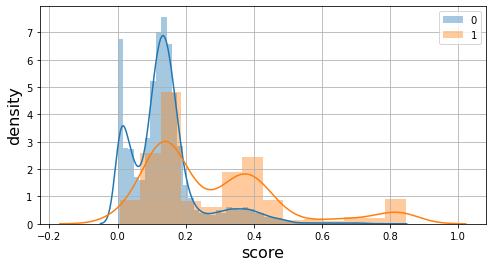

In [43]:
plt.figure(figsize=(8,4))
sns.distplot(y_pred_test_rnn[y_test==0], label='0')
sns.distplot(y_pred_test_rnn[y_test==1], label='1')
plt.xlabel('score', fontsize=16)
plt.ylabel('density', fontsize=16)
plt.legend()
plt.grid()

## LSTM-NN

In [44]:
%%time
features_names = variables_categoricas + feauture_selected
spents_names = variables_consumo
lstm_nn_model = LSTMNNModel(features_names,spents_names,sampling_th = sam_th,preprocesor_num = preprocesor,sampling_method=param_imb_method)
lstm_rnn_model,pipe_features,pipe_spent = lstm_nn_model.train(df_train,y_train)

Restoring model weights from the end of the best epoch.
Epoch 00079: early stopping
CPU times: user 6min 43s, sys: 5min 23s, total: 12min 6s
Wall time: 1min 1s


In [45]:
X_test_features = pipe_features.transform(df_test[features_names])
X_test_spents = pipe_spent.transform(df_test[spents_names])
X_test_spents = X_test_spents.reshape((X_test_spents.shape[0],periodo,1))

In [46]:
y_pred_test_lstm_rnn = lstm_rnn_model.predict([X_test_spents, X_test_features],batch_size=lstm_nn_model.BATCH_SIZE)[:,0]
resulado_final[f'{param_imb_method}-lstm-ffn'] = y_pred_test_lstm_rnn

In [47]:
print("AUC Test:  %.3f" %  roc_auc_score(y_test,y_pred_test_lstm_rnn))

AUC Test:  0.732


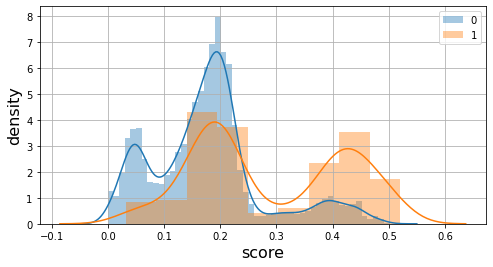

In [48]:
plt.figure(figsize=(8,4))
sns.distplot(y_pred_test_lstm_rnn[y_test==0], label='0')
sns.distplot(y_pred_test_lstm_rnn[y_test==1], label='1')
plt.xlabel('score', fontsize=16)
plt.ylabel('density', fontsize=16)
plt.legend()
plt.grid()

## Paso 5 - Resultado Final

In [49]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
mpl.rcParams['figure.figsize'] = (10, 6)

,metodo,auc
0,under-lgbm,0.78
1,under-ffn,0.73
2,under-lstm-ffn,0.73


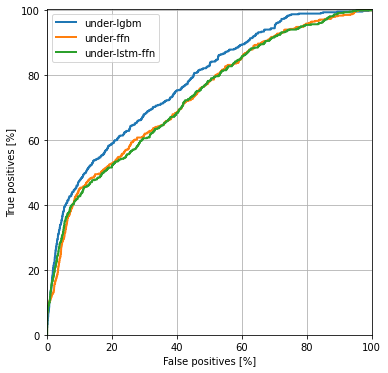

In [50]:
l_m_auc = []

for i,x in enumerate(resulado_final.keys()):
    plot_roc(x, y_test,resulado_final[x] , color=colors[i])
    m_auc = roc_auc_score(y_test,resulado_final[x])
    l_m_auc.append((x,m_auc))
plt.legend();

pd.DataFrame(l_m_auc, columns=['metodo','auc']).sort_values('auc',ascending=False)

In [51]:
print('FIN')

FIN


***